In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
import time
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# minist数据集
mnist_train = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='~/Datasets/MNIST',train=False, transform=transforms.ToTensor())
# 通过DataLoader 读取小批量数据样本
batch_size = 128
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=0)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

In [3]:
# 绘图函数
import matplotlib.pyplot as plt
def draw_loss(train_loss, test_acc):
    x = range(len(train_loss))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(10, 5))
    # 在第一个子图中绘制训练损失
    plt.subplot(1, 2, 1)
    plt.plot(x, train_loss, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    # 在第二个子图中绘制测试精度
    plt.subplot(1, 2, 2)
    plt.plot(x, test_acc, color='r', label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# 测试准确率评价函数
def evaluate_accuracy(data_iter, model):
    acc_sum, n= 0.0, 0
    for X, y in data_iter:
        result = model.forward(X)
        acc_sum += (result.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
        self.W1 = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_inputs)), dtype=torch.float, requires_grad=True))
        self.b1 = nn.Parameter(torch.zeros(num_hiddens1, requires_grad=True))
        self.W2 = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_hiddens1)), dtype=torch.float, requires_grad=True))
        self.b2 = nn.Parameter(torch.zeros(num_hiddens2, requires_grad=True))
        self.W3 = nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(num_outputs, num_hiddens2)), dtype=torch.float, requires_grad=True))
        self.b3 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
        self.params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer1 = lambda x: torch.matmul(x, self.W1.t()) + self.b1
        self.hidden_layer2 = lambda x: torch.matmul(x, self.W2.t()) + self.b2
        self.output_layer = lambda x: torch.matmul(x, self.W3.t()) + self.b3
    
    def forward(self, x):
        # 定义前向传播
        x = self.input_layer(x)
        x = nn.ReLU()(self.hidden_layer1(x))
        x = nn.ReLU()(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

In [6]:
# 手动实现RMSprop算法
def init_rmsprop_states(params):
    states = []
    for p in params:
        states.append(torch.zeros_like(p))
    return states
def rmsprop(params, states, lr, gamma, eps=1e-6):
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= lr * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

In [7]:
# 训练函数
def train1(net, train_iter, loss, epochs, gamma):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    params = list(net.parameters())
    states = init_rmsprop_states(params)
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            rmsprop(params, states, lr, gamma)
            for p in params:
                if p.grad is not None:
                    p.grad.data.zero_()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, test_acc_list)

epoch 1, train loss 0.3877, train acc 0.876, test acc 0.942
epoch 2, train loss 0.1503, train acc 0.956, test acc 0.955
epoch 3, train loss 0.1247, train acc 0.965, test acc 0.962
epoch 4, train loss 0.1069, train acc 0.970, test acc 0.964
epoch 5, train loss 0.0993, train acc 0.973, test acc 0.968
epoch 6, train loss 0.0943, train acc 0.975, test acc 0.964
epoch 7, train loss 0.0875, train acc 0.978, test acc 0.966
epoch 8, train loss 0.0848, train acc 0.978, test acc 0.963
epoch 9, train loss 0.0838, train acc 0.980, test acc 0.967
epoch 10, train loss 0.0827, train acc 0.981, test acc 0.965
epoch 11, train loss 0.0785, train acc 0.982, test acc 0.968
epoch 12, train loss 0.0746, train acc 0.983, test acc 0.965
epoch 13, train loss 0.0775, train acc 0.983, test acc 0.972
epoch 14, train loss 0.0714, train acc 0.985, test acc 0.971
epoch 15, train loss 0.0748, train acc 0.984, test acc 0.974
epoch 16, train loss 0.0686, train acc 0.986, test acc 0.972
epoch 17, train loss 0.0661, trai

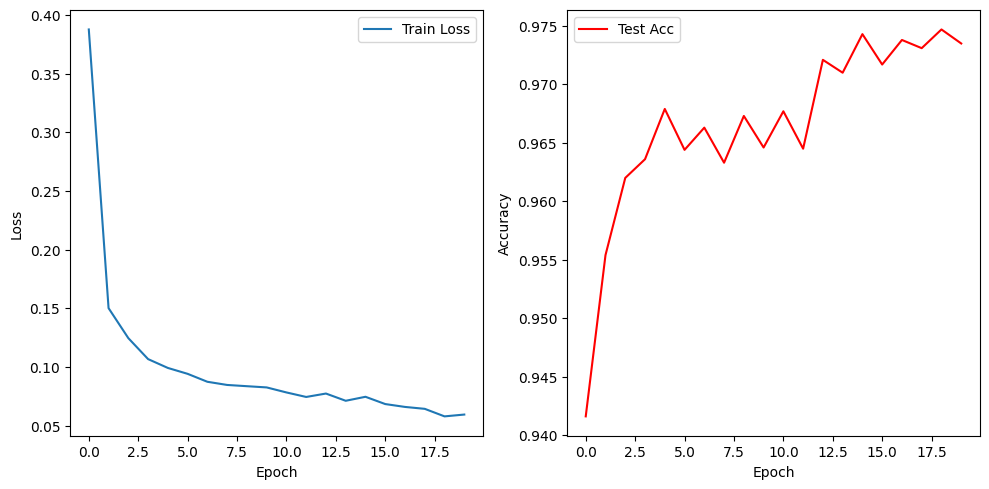

In [8]:
epochs = 20
lr = 0.01
loss = nn.CrossEntropyLoss()
net = Net()
gamma = 0.9
train1(net, train_iter, loss, epochs, gamma)

In [9]:
def train2(net, train_iter, loss, epochs, optimizer):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        for X,y in train_iter:
            y_hat = net.forward(X)
            l = loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, test_acc_list)

epoch 1, train loss 0.7920, train acc 0.866, test acc 0.932
epoch 2, train loss 0.2027, train acc 0.941, test acc 0.932
epoch 3, train loss 0.1617, train acc 0.953, test acc 0.949
epoch 4, train loss 0.1413, train acc 0.959, test acc 0.957
epoch 5, train loss 0.1242, train acc 0.964, test acc 0.951
epoch 6, train loss 0.1155, train acc 0.967, test acc 0.959
epoch 7, train loss 0.1096, train acc 0.969, test acc 0.962
epoch 8, train loss 0.1043, train acc 0.971, test acc 0.961
epoch 9, train loss 0.0993, train acc 0.972, test acc 0.964
epoch 10, train loss 0.0965, train acc 0.973, test acc 0.966
epoch 11, train loss 0.0922, train acc 0.975, test acc 0.957
epoch 12, train loss 0.0865, train acc 0.976, test acc 0.963
epoch 13, train loss 0.0811, train acc 0.977, test acc 0.962
epoch 14, train loss 0.0846, train acc 0.977, test acc 0.929
epoch 15, train loss 0.0843, train acc 0.978, test acc 0.965
epoch 16, train loss 0.0780, train acc 0.979, test acc 0.964
epoch 17, train loss 0.0786, trai

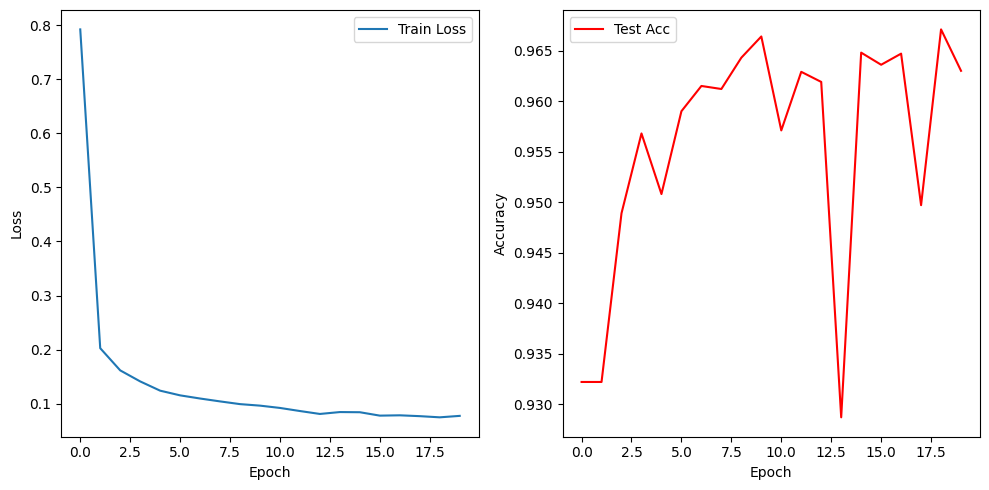

In [10]:
net = Net()
optimizer = torch.optim.RMSprop(net.parameters(), lr, alpha=0.99, eps=1e-6)
train2(net, train_iter, loss, epochs, optimizer)

In [11]:
# 手动实现momentum算法
def init_momentum_states(params):
    states = []
    for p in params:
        states.append(torch.zeros_like(p))
    return states
def sgd_momentum(params, states , lr, momentum):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = momentum * v - p.grad
            p[:] += lr * v
        p.grad.data.zero_()

In [12]:
def train3(net, train_iter, loss, epochs, momentum):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    params = list(net.parameters())
    states = init_rmsprop_states(params)
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            sgd_momentum(params, states, lr, momentum)
            for p in params:
                if p.grad is not None:
                    p.grad.data.zero_()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, test_acc_list)

epoch 1, train loss 2.2988, train acc 0.112, test acc 0.115
epoch 2, train loss 2.2197, train acc 0.234, test acc 0.321
epoch 3, train loss 1.3302, train acc 0.579, test acc 0.750
epoch 4, train loss 0.7033, train acc 0.784, test acc 0.825
epoch 5, train loss 0.5483, train acc 0.841, test acc 0.864
epoch 6, train loss 0.4564, train acc 0.869, test acc 0.880
epoch 7, train loss 0.4051, train acc 0.885, test acc 0.890
epoch 8, train loss 0.3709, train acc 0.895, test acc 0.899
epoch 9, train loss 0.3451, train acc 0.903, test acc 0.904
epoch 10, train loss 0.3237, train acc 0.909, test acc 0.910
epoch 11, train loss 0.3049, train acc 0.914, test acc 0.915
epoch 12, train loss 0.2876, train acc 0.918, test acc 0.921
epoch 13, train loss 0.2709, train acc 0.923, test acc 0.927
epoch 14, train loss 0.2554, train acc 0.928, test acc 0.931
epoch 15, train loss 0.2405, train acc 0.932, test acc 0.934
epoch 16, train loss 0.2266, train acc 0.936, test acc 0.940
epoch 17, train loss 0.2140, trai

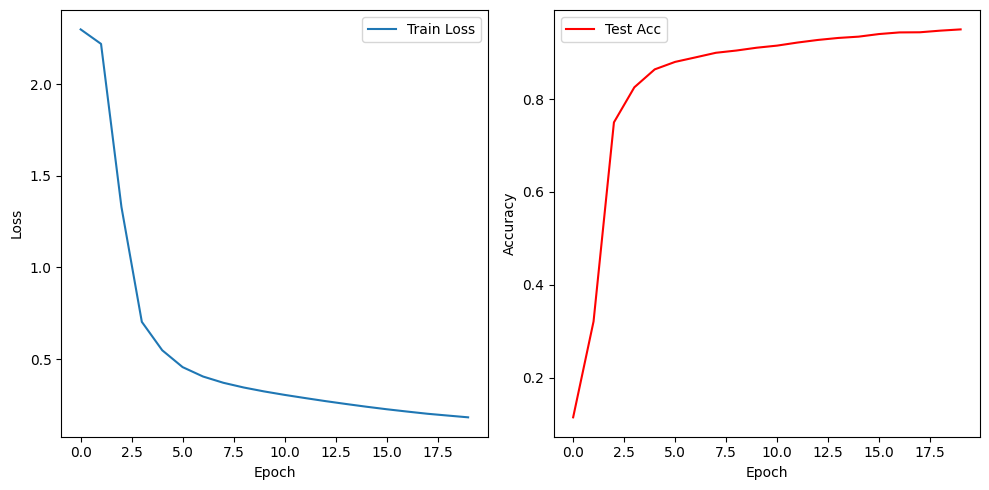

In [13]:
net = Net()
momentum = 0.5
train3(net, train_iter, loss, epochs, momentum)

epoch 1, train loss 2.2992, train acc 0.129, test acc 0.114
epoch 2, train loss 2.2435, train acc 0.219, test acc 0.314
epoch 3, train loss 1.4221, train acc 0.569, test acc 0.749
epoch 4, train loss 0.6979, train acc 0.785, test acc 0.829
epoch 5, train loss 0.5299, train acc 0.847, test acc 0.866
epoch 6, train loss 0.4419, train acc 0.874, test acc 0.885
epoch 7, train loss 0.3918, train acc 0.888, test acc 0.895
epoch 8, train loss 0.3588, train acc 0.898, test acc 0.900
epoch 9, train loss 0.3348, train acc 0.904, test acc 0.906
epoch 10, train loss 0.3154, train acc 0.911, test acc 0.912
epoch 11, train loss 0.2974, train acc 0.916, test acc 0.919
epoch 12, train loss 0.2806, train acc 0.921, test acc 0.923
epoch 13, train loss 0.2643, train acc 0.925, test acc 0.928
epoch 14, train loss 0.2488, train acc 0.930, test acc 0.932
epoch 15, train loss 0.2344, train acc 0.934, test acc 0.935
epoch 16, train loss 0.2206, train acc 0.938, test acc 0.940
epoch 17, train loss 0.2081, trai

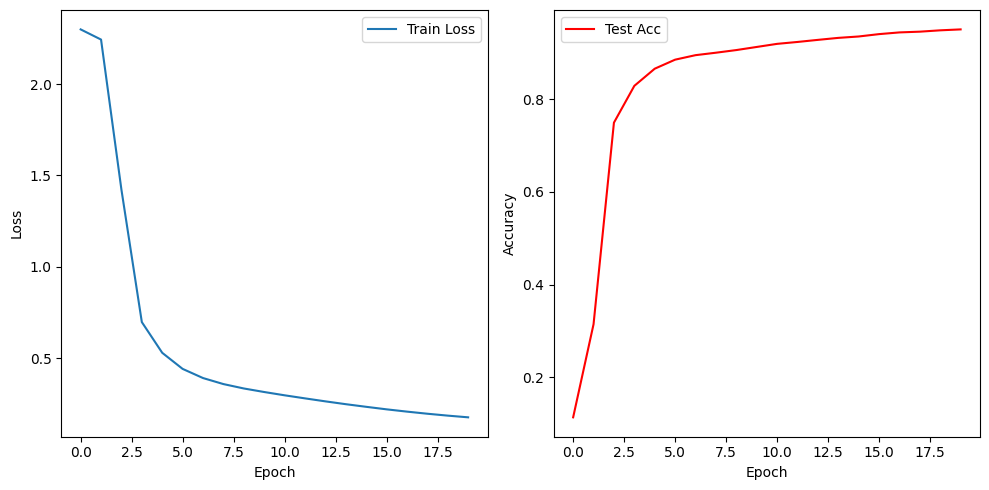

In [14]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), lr, momentum=0.5)
train2(net, train_iter, loss, epochs, optimizer)

In [15]:
# 手动实现Adam算法
def init_adam_states(params):
    states = []
    for p in params:
        states.append((torch.zeros_like(p), torch.zeros_like(p)))
    return states
def adam(params, states , lr, t):
    beta1, beta2, eps =0.9, 0.999, 1e-6 
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # Compute the first and second moment
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * p.grad**2
            # Bias correction
            v_hat = v / (1 - beta1 ** t)
            s_hat = s / (1 - beta2 ** t)
            # Update the parameters
            p -= lr * v_hat / (torch.sqrt(s_hat) + eps)
        p.grad.data.zero_()
    t += 1

In [16]:
def train3(net, train_iter, loss, epochs, t):
    train_loss_list = []
    test_acc_list = []
    time_start = time.time()
    params = list(net.parameters())
    states = init_adam_states(params)
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, c = 0.0,0.0, 0,0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            for p in params:
                if p.grad is not None:
                    p.grad.data.zero_()
            l.backward()
            adam(params, states, lr, t)
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc = evaluate_accuracy(test_iter, net)
        train_loss_list.append(train_l_sum / c)
        test_acc_list.append(test_acc)
        print('epoch %d, train loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / c, train_acc_sum / n, test_acc))
    print("time spend: %.6f second" % (time.time() - time_start))
    draw_loss(train_loss_list, test_acc_list)

epoch 1, train loss 0.2308, train acc 0.928, test acc 0.966
epoch 2, train loss 0.0864, train acc 0.973, test acc 0.970
epoch 3, train loss 0.0623, train acc 0.980, test acc 0.974
epoch 4, train loss 0.0436, train acc 0.986, test acc 0.977
epoch 5, train loss 0.0335, train acc 0.989, test acc 0.976
epoch 6, train loss 0.0281, train acc 0.991, test acc 0.975
epoch 7, train loss 0.0275, train acc 0.991, test acc 0.972
epoch 8, train loss 0.0245, train acc 0.992, test acc 0.975
epoch 9, train loss 0.0194, train acc 0.994, test acc 0.976
epoch 10, train loss 0.0186, train acc 0.994, test acc 0.977
epoch 11, train loss 0.0178, train acc 0.995, test acc 0.972
epoch 12, train loss 0.0198, train acc 0.994, test acc 0.975
epoch 13, train loss 0.0178, train acc 0.995, test acc 0.979
epoch 14, train loss 0.0141, train acc 0.996, test acc 0.979
epoch 15, train loss 0.0191, train acc 0.994, test acc 0.976
epoch 16, train loss 0.0128, train acc 0.996, test acc 0.977
epoch 17, train loss 0.0112, trai

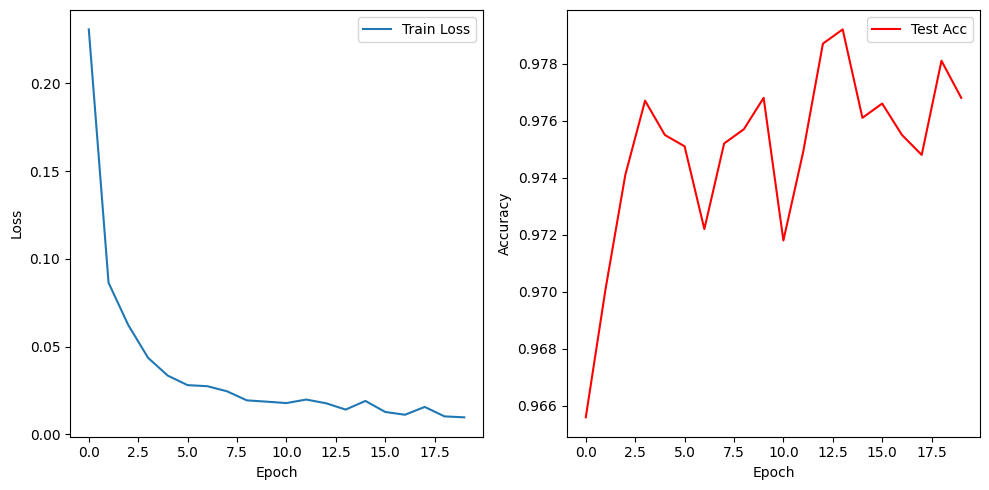

In [17]:
net = Net()
t = 1
train3(net, train_iter, loss, epochs, t)

epoch 1, train loss 0.2559, train acc 0.921, test acc 0.955
epoch 2, train loss 0.1295, train acc 0.963, test acc 0.957
epoch 3, train loss 0.1053, train acc 0.969, test acc 0.964
epoch 4, train loss 0.0959, train acc 0.974, test acc 0.951
epoch 5, train loss 0.0897, train acc 0.975, test acc 0.966
epoch 6, train loss 0.0801, train acc 0.978, test acc 0.966
epoch 7, train loss 0.0801, train acc 0.979, test acc 0.960
epoch 8, train loss 0.0714, train acc 0.981, test acc 0.969
epoch 9, train loss 0.0641, train acc 0.983, test acc 0.964
epoch 10, train loss 0.0691, train acc 0.982, test acc 0.965
epoch 11, train loss 0.0637, train acc 0.983, test acc 0.972
epoch 12, train loss 0.0601, train acc 0.985, test acc 0.970
epoch 13, train loss 0.0536, train acc 0.985, test acc 0.969
epoch 14, train loss 0.0544, train acc 0.986, test acc 0.973
epoch 15, train loss 0.0611, train acc 0.985, test acc 0.970
epoch 16, train loss 0.0538, train acc 0.987, test acc 0.971
epoch 17, train loss 0.0500, trai

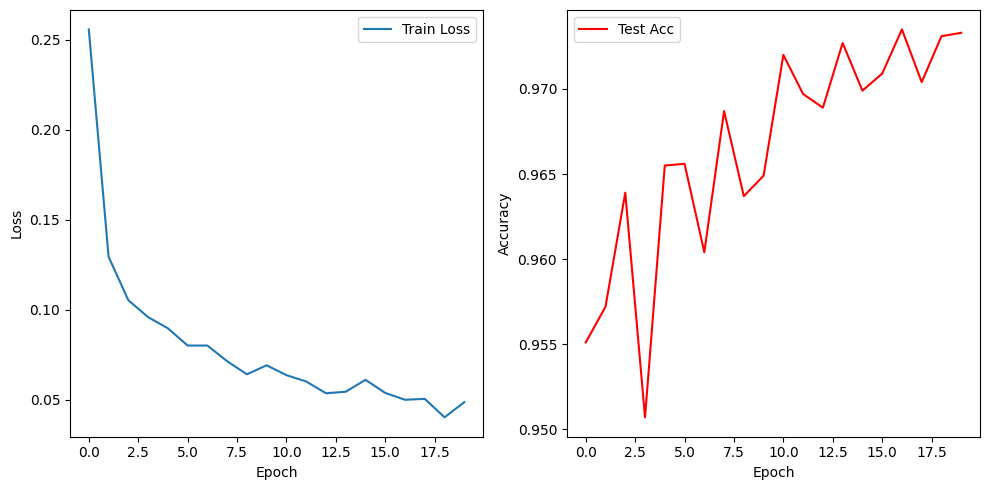

In [18]:
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr)
train2(net, train_iter, loss, epochs, optimizer)